# 1. Necessary Imports

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')

import datetime as dt
import dateutil
import string

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

import importlib

# 2. Reading the data

In [2]:
df_dtype = {'airline':str,
            'overall':'Int64',
            'author':str,
            'review_date':str,
            'customer_review':str,
            'aircraft':str,
            'traveller_type':str,
            'cabin':str,
            'route':str,
            'date_flown':str,
            'seat_comfort':'Int64',
            'cabin_service':'Int64',
            'food_bev':'Int64',
            'entertainment':'Int64',
            'ground_service':'Int64',
            'value_for_money':'Int64',
            'recommended':str,
           }

In [4]:
df = pd.read_excel('capstone_airline_reviews3.xlsx', dtype=df_dtype)
df.head()

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
1,Turkish Airlines,7,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4,5,4,4,2,4,yes
2,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
3,Turkish Airlines,2,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4,1,1,1,1,1,no
4,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN


In [5]:
df.shape

(131895, 17)

In [6]:
cols = df.columns.to_list()
print('Columns in the dataset:')
print(cols)

Columns in the dataset:
['airline', 'overall', 'author', 'review_date', 'customer_review', 'aircraft', 'traveller_type', 'cabin', 'route', 'date_flown', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'recommended']


In [7]:
n_reviews = df.shape[0]
print('Number of customer reviews in the dataset: {:d}'.format(n_reviews))

Number of customer reviews in the dataset: 131895


The preview of the dataset shows that the customer review field usually starts with a special character and a default text, followed by the same information displayed in the route field. We can strip this information away from the customer review field as it does not add any additional value.

# 3. Preliminary fixes of the input data

## 3.1 Cleaning the customer review text

In [8]:
df[['customer_review','route']].head()

,customer_review,route
0,NaN,NaN
1,âœ… Trip Verified | London to Izmir via Istanb...,London to Izmir via Istanbul
2,NaN,NaN
3,âœ… Trip Verified | Istanbul to Bucharest. We ...,Istanbul to Bucharest
4,NaN,NaN


In [9]:
df.iloc[1,:]['customer_review']

'âœ… Trip Verified | London to Izmir via Istanbul. First time Iâ€™d flown TK. I found them very good in the air, cabin crew, planes, food, all very nice. Not so great on the ground, ground staff, call centre, computer systems. My flight from LHR was delayed so I missed the connection in Istanbul. Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English. I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats. However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat. Luckily there was a spare exit row seat and the cabin crew sorted me out. Overall, I think their cabin crew and pl

In [10]:
df.iloc[1,:]['route']

'London to Izmir via Istanbul'

In [11]:
df_quick_fixes = df.copy()

In [12]:
# Split the string by the first occurrence of '.' and get the second part of the string.
df_quick_fixes['customer_review_clean'] = df_quick_fixes['customer_review'].str.split('.',n=1,expand=True)[1]

In [13]:
df_quick_fixes['customer_review_clean'].head()

0                                                  NaN
1     First time Iâ€™d flown TK. I found them very ...
2                                                  NaN
3     We make our check in in the airport, they Tak...
4                                                  NaN
Name: customer_review_clean, dtype: object

In [14]:
df_quick_fixes.drop(columns=['customer_review'], inplace=True)

In [15]:
df_quick_fixes.head()

,airline,overall,author,review_date,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended,customer_review_clean
0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
1,Turkish Airlines,7,Christopher Hackley,8th May 2019,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4,5,4,4,2,4,yes,First time Iâ€™d flown TK. I found them very ...
2,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
3,Turkish Airlines,2,Adriana Pisoi,7th May 2019,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4,1,1,1,1,1,no,"We make our check in in the airport, they Tak..."
4,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN


## 3.2 Rename the columns and remove the irrelavant columns

In [16]:
# For ease of access, we rename some columns
df_quick_fixes.rename(columns={'overall':'review_score', 'customer_review_clean':'review_text'}, inplace=True)

In [17]:
# Drop the author field as we don't need it.
df_quick_fixes.drop(columns=['author'], inplace=True)

In [18]:
df_quick_fixes.head()

,airline,review_score,review_date,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended,review_text
0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
1,Turkish Airlines,7,8th May 2019,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4,5,4,4,2,4,yes,First time Iâ€™d flown TK. I found them very ...
2,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
3,Turkish Airlines,2,7th May 2019,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4,1,1,1,1,1,no,"We make our check in in the airport, they Tak..."
4,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN


# 4. Feature Engineering

In [19]:
# A copy so that the original one isn't manipulated
df_aug = df_quick_fixes.copy()

## 4.1 Handling the dates 

The following features are added to the dataset:

* review_date_timestamp
* review_date_day
* review_date_month
* review_date_year
* review_date_sec_epoch
* date_flown_timestamp
* date_flown_day
* date_flown_month
* date_flown_year
* date_flown_sec_epoch
* review_date_date_flown_distance_days

In [20]:
df_aug[['review_date','date_flown']].dtypes

review_date    object
date_flown     object
dtype: object

In [21]:
df_aug[['review_date','date_flown']].head()

,review_date,date_flown
0,NaN,NaN
1,8th May 2019,2019-05-01 00:00:00
2,NaN,NaN
3,7th May 2019,2019-05-01 00:00:00
4,NaN,NaN


In [22]:
# datetime timestamp
def get_review_date_timestamp(df_row):
    """
    Return the timestamp of the review date.
    """
    review_date_timestamp = None
    if (str(df_row['review_date']) == 'nan'):
        review_date_timestamp = None
    else:
        review_date_timestamp = dateutil.parser.parse(df_row['review_date'])
    return review_date_timestamp

In [23]:
df_aug['review_date_timestamp'] = df_aug.apply(lambda x: get_review_date_timestamp(x), axis=1)

In [24]:
df_aug[['review_date','review_date_timestamp']].head()

,review_date,review_date_timestamp
0,NaN,NaT
1,8th May 2019,2019-05-08
2,NaN,NaT
3,7th May 2019,2019-05-07
4,NaN,NaT


In [25]:
# Fetch the day
def get_review_date_day(df_row):
    """
    Return the day of the review date.
    """
    review_date_day = None
    if (str(df_row['review_date_timestamp']) == 'NaT'):
        review_date_day = None
    else:
        review_date_day = df_row['review_date_timestamp'].day
    return review_date_day

# Fetch the month
def get_review_date_month(df_row):
    """
    Return the month of the review date.
    """
    review_date_month = None
    if (str(df_row['review_date_timestamp']) == 'NaT'):
        review_date_month = None
    else:
        review_date_month = df_row['review_date_timestamp'].month
    return review_date_month

# Fetch the year
def get_review_date_year(df_row):
    """
    Return the year of the review date.
    """
    review_date_year = None
    if (str(df_row['review_date_timestamp']) == 'NaT'):
        review_date_year = None
    else:
        review_date_year = df_row['review_date_timestamp'].year
    return review_date_year

In [26]:
# Add other augmented features
df_aug['review_date_day'] = df_aug.apply(lambda x: get_review_date_day(x),axis=1)
df_aug['review_date_month'] = df_aug.apply(lambda x: get_review_date_month(x),axis=1)
df_aug['review_date_year'] = df_aug.apply(lambda x: get_review_date_year(x),axis=1)

In [27]:
df_aug[['review_date','review_date_timestamp','review_date_day','review_date_month','review_date_year']].head()

,review_date,review_date_timestamp,review_date_day,review_date_month,review_date_year
0,NaN,NaT,NaN,NaN,NaN
1,8th May 2019,2019-05-08,8.0,5.0,2019.0
2,NaN,NaT,NaN,NaN,NaN
3,7th May 2019,2019-05-07,7.0,5.0,2019.0
4,NaN,NaT,NaN,NaN,NaN


In [28]:
# Fetch the number of seconds the review date
def get_review_date_sec_epoch(df_row):
    """
    Return the seconds since the epoch of the review date.
    """
    review_date_sec_epoch = None
    if (str(df_row['review_date_timestamp']) == 'NaT'):
        review_date_sec_epoch = None
    else:
        review_date_sec_epoch = df_row['review_date_timestamp'].timestamp()
    return review_date_sec_epoch

In [29]:
df_aug['review_date_sec_epoch'] = df_aug.apply(lambda x: get_review_date_sec_epoch(x),axis=1)
df_aug[['review_date','review_date_timestamp','review_date_day','review_date_month','review_date_year','review_date_sec_epoch']].head()

,review_date,review_date_timestamp,review_date_day,review_date_month,review_date_year,review_date_sec_epoch
0,NaN,NaT,NaN,NaN,NaN,NaN
1,8th May 2019,2019-05-08,8.0,5.0,2019.0,1.557274e+09
2,NaN,NaT,NaN,NaN,NaN,NaN
3,7th May 2019,2019-05-07,7.0,5.0,2019.0,1.557187e+09
4,NaN,NaT,NaN,NaN,NaN,NaN


In [30]:
def get_date_flown_timestamp(df_row):
    """
    Return the timestamp of the date flown.
    """
    date_flown_timestamp = None
    if (str(df_row['date_flown']) == 'nan'):
        date_flown_timestamp = None
    elif (isinstance(df_row['date_flown'],dt.datetime)):
        date_flown_timestamp = df_row['date_flown']
    else:
        date_flown_timestamp = dateutil.parser.parse(df_row['date_flown'])
    return date_flown_timestamp

In [31]:
df_aug['date_flown_timestamp'] = df_aug.apply(lambda x: get_date_flown_timestamp(x), axis=1)

In [32]:
df_aug[['date_flown','date_flown_timestamp']].head()

,date_flown,date_flown_timestamp
0,NaN,NaT
1,2019-05-01 00:00:00,2019-05-01
2,NaN,NaT
3,2019-05-01 00:00:00,2019-05-01
4,NaN,NaT


In [33]:
def get_date_flown_day(df_row):
    """
    Return the day of the date flown.
    """
    date_flown_day = None
    if (str(df_row['date_flown_timestamp']) == 'NaT'):
        date_flown_day = None
    else:
        date_flown_day = df_row['date_flown_timestamp'].day
    return date_flown_day

def get_date_flown_month(df_row):
    """
    Return the month of the date flown.
    """
    date_flown_month = None
    if (str(df_row['date_flown_timestamp']) == 'NaT'):
        date_flown_month = None
    else:
        date_flown_month = df_row['date_flown_timestamp'].month
    return date_flown_month

def get_date_flown_year(df_row):
    """
    Return the year of the date flown.
    """
    date_flown_year = None
    if (str(df_row['date_flown_timestamp']) == 'NaT'):
        date_flown_year = None
    else:
        date_flown_year = df_row['date_flown_timestamp'].year
    return date_flown_year

In [34]:
# Add some more features
df_aug['date_flown_day'] = df_aug.apply(lambda x: get_date_flown_day(x),axis=1)
df_aug['date_flown_month'] = df_aug.apply(lambda x: get_date_flown_month(x),axis=1)
df_aug['date_flown_year'] = df_aug.apply(lambda x: get_date_flown_year(x),axis=1)

In [35]:
def get_date_flown_sec_epoch(df_row):
    """
    Return the seconds since the epoch of the date flown.
    """
    date_flown_sec_epoch = None
    if (str(df_row['date_flown_timestamp']) == 'NaT'):
        date_flown_sec_epoch = None
    else:
        date_flown_sec_epoch = df_row['date_flown_timestamp'].timestamp()
    return date_flown_sec_epoch

In [36]:
df_aug['date_flown_sec_epoch'] = df_aug.apply(lambda x: get_date_flown_sec_epoch(x),axis=1)
df_aug[['date_flown','date_flown_timestamp','date_flown_day','date_flown_month','date_flown_year','date_flown_sec_epoch']].head()

,date_flown,date_flown_timestamp,date_flown_day,date_flown_month,date_flown_year,date_flown_sec_epoch
0,NaN,NaT,NaN,NaN,NaN,NaN
1,2019-05-01 00:00:00,2019-05-01,1.0,5.0,2019.0,1.556669e+09
2,NaN,NaT,NaN,NaN,NaN,NaN
3,2019-05-01 00:00:00,2019-05-01,1.0,5.0,2019.0,1.556669e+09
4,NaN,NaT,NaN,NaN,NaN,NaN


In [37]:
def get_review_date_date_flown_distance_days(df_row):
    """
    Return the time distance in days from the date flown to the review date.
    """
    review_date_date_flown_distance_days = None
    if (df_row['review_date_timestamp'] is None or df_row['date_flown_timestamp'] is None or df_row['review_date'] == pd.NaT or df_row['date_flown'] == pd.NaT or df_row['review_date_timestamp'] == np.NaN or df_row['date_flown_timestamp'] == np.NaN or str(df_row['review_date_timestamp']) == 'NaT' or str(df_row['date_flown_timestamp']) == 'NaT'):
        review_date_date_flown_distance_days = None
    else:
        # print(df_row['review_date_timestamp'])
        # print(df_row['date_flown_timestamp'])
        # review_date_flown_distance = dt.datetime.fromtimestamp(df_row['review_date_timestamp'])-dt.datetime.fromtimestamp(df_row['date_flown_timestamp'])
        review_date_date_flown_distance = df_row['review_date_timestamp']-df_row['date_flown_timestamp']
        review_date_date_flown_distance_days = review_date_date_flown_distance.days
    return review_date_date_flown_distance_days

In [38]:
# Add the difference of days between the travel date and the review date
df_aug['review_date_date_flown_distance_days'] = df_aug.apply(lambda x: get_review_date_date_flown_distance_days(x),axis=1)
df_aug['review_date_date_flown_distance_days'].dtype

dtype('float64')

In [39]:
df_aug[['date_flown_timestamp','review_date_timestamp','review_date_date_flown_distance_days']].head()

,date_flown_timestamp,review_date_timestamp,review_date_date_flown_distance_days
0,NaT,NaT,NaN
1,2019-05-01,2019-05-08,7.0
2,NaT,NaT,NaN
3,2019-05-01,2019-05-07,6.0
4,NaT,NaT,NaN


## 4.2 Check for completeness of review string

In [40]:
# We will add another feature stating if the review is complete or not i.e. True if all fields are there and False otherwise
def get_completeness(df_row):
    """
    Return true if the review contains all fields and false otherwise.
    """
    is_complete = None
    is_not_complete = df_row.isnull().any()
    if (is_not_complete == True):
        is_complete = False
    else:
        is_complete = True
    return is_complete

In [41]:
df_aug['is_complete'] = df_aug.apply(lambda x: get_completeness(x),axis=1)
df_aug['is_complete'].head()

0    False
1    False
2    False
3    False
4    False
Name: is_complete, dtype: bool

## 4.3 Review length

In [42]:
# We will add 2 more features indicating the characters and words respectively.
def get_review_characters(df_row):
    """
    Return the number of characters in the review.
    """
    review_characters = None
    if (str(df_row['review_text'])=='nan' or df_row['review_text'] is None):
        review_characters = 0
    else:
        review_characters = len(df_row['review_text'])
    return review_characters

def get_review_words(df_row):
    """
    Return the number of words in the review.
    """
    review_words = None
    if (str(df_row['review_text'])=='nan' or df_row['review_text'] is None):
        review_words = 0
    else:
        review_words = len(df_row['review_text'].split(' '))
    return review_words

In [43]:
df_aug['review_characters'] = df_aug.apply(lambda x: get_review_characters(x),axis=1)
df_aug['review_words'] = df_aug.apply(lambda x: get_review_words(x),axis=1)

In [44]:
df_aug[['review_characters', 'review_words']].head()

,review_characters,review_words
0,0,0
1,1094,200
2,0,0
3,425,83
4,0,0


## 4.4 Manipulating the review scores

In [45]:
df_aug['review_score'].unique()

<IntegerArray>
[<NA>, 7, 2, 3, 10, 1, 6, 8, 5, 4, 9]
Length: 11, dtype: Int64

In [46]:
df_aug['review_score'].describe()

count    64017.000000
mean         5.145430
std          3.477532
min          1.000000
25%          1.000000
50%          5.000000
75%          9.000000
max         10.000000
Name: review_score, dtype: float64

In [47]:
# We will classify the review score into one of the 3 categories: Positive, Neutral and Negative
def get_pos_neu_neg_review_score(df_row):
    """
    Return:
    - 'pos' if the review score is positive (>=7),
    - 'neu' if the review score is neutral (5 or 6),
    - 'neg' if the review score is negative (<=4).
    """
    pos_neu_neg_review_score = None
    if (df_row['review_score'] is None or str(df_row['review_score']) == '<NA>'):
        pos_neu_neg_review_score = None
    else:
        if (df_row['review_score'] <= 4):
            pos_neu_neg_review_score = 'neg'
        elif (df_row['review_score'] > 4 and df_row['review_score'] <= 6):
            pos_neu_neg_review_score = 'neu'
        else:
            pos_neu_neg_review_score = 'pos'
    return pos_neu_neg_review_score

In [48]:
df_aug['pos_neu_neg_review_score'] = df_aug.apply(lambda x: get_pos_neu_neg_review_score(x),axis=1)
df_aug[['review_score','pos_neu_neg_review_score']].head()

,review_score,pos_neu_neg_review_score
0,<NA>,None
1,7,pos
2,<NA>,None
3,2,neg
4,<NA>,None


In [49]:
print('Number of unique values: {:d}'.format(df_aug['aircraft'].nunique()))
df_aug.groupby(['aircraft']).size().sort_values(ascending=False).reset_index(name='frequency')

Number of unique values: 2088


,aircraft,frequency
0,A320,2157
1,Boeing 777,1215
2,A380,1109
3,A330,1074
4,Boeing 737-800,1036
...,...,...
2083,B737-800 / Embraer 190,1
2084,B737-700 / B737-800,1
2085,B737-600 and B737-800,1
2086,B737-600,1


In [50]:
df_aug.drop(columns=['aircraft'],inplace=True)

## 4.5 Get separate columns for route, destination and layovers

In [51]:
def get_origin(df_row):
    """
    Return the origin of the flight.
    """
    origin = None
    if str(df_row['route'])=='nan':
        origin = None
    else:
        origin = df_row['route'].split(' to ')[0]
    return origin

def get_destination(df_row):
    """
    Return the destination of the flight.
    """
    destination = None
    if str(df_row['route'])=='nan':
        destination = None
    else:
        # print(df_row['route'])
        temp = df_row['route'].split(' to ')
        # Standard case, there is a string before ' to ' and a string after ' to '.
        if len(temp)==2:
            destination = temp[1].split(' via ')[0]
        # Special case, the second space in ' to ' is missing.
        elif len(temp)==1:
            temp2 = df_row['route'].split(' to')
            if len(temp2)==2:
                destination = temp2[1].split(' via ')[0]
        else:
            destination = None
    return destination

def get_layover(df_row):
    """
    Return the layover of the flight.
    """
    layover = None
    if str(df_row['route'])=='nan':
        layover = None
    else:
        # print(df_row['route'])
        temp = df_row['route'].split(' via ')
        # There is no ' via ' in the route, no layover.
        if len(temp) == 1:
            layover = 'NA'
        # There is a ' via ' in the route, layover available.
        elif len(temp) == 2:
            layover = temp[1]
        else:
            layover = None
    return layover

In [52]:
df_aug['origin'] = df_aug.apply(lambda x: get_origin(x), axis=1)
df_aug['destination'] = df_aug.apply(lambda x: get_destination(x), axis=1)
df_aug['layover'] = df_aug.apply(lambda x: get_layover(x), axis=1)

In [53]:
# Add another feature if the flight has a layover
def has_layover(df_row):
    """
    Return True if the review score corresponds to a flight with layover and False otherwise.
    """
    layover = False
    if df_row['layover'] is not None and str(df_row['layover']) != 'NA':
        layover = True
    return layover

In [54]:
df_aug['has_layover'] = df_aug.apply(lambda x: has_layover(x), axis=1)
df_aug[['route','origin','destination','layover','has_layover']].head()

,route,origin,destination,layover,has_layover
0,NaN,None,None,None,False
1,London to Izmir via Istanbul,London,Izmir,Istanbul,True
2,NaN,None,None,None,False
3,Istanbul to Bucharest,Istanbul,Bucharest,NA,False
4,NaN,None,None,None,False


In [55]:
df_aug.shape

(131895, 34)

In [56]:
df_aug[df_aug['has_layover']==False].shape

(119137, 34)

In [57]:
df_aug[df_aug['has_layover']==True].shape

(12758, 34)

In [58]:
df_aug['origin'].unique().tolist()

[None,
 'London',
 'Istanbul',
 'Rome',
 'Washington Dulles',
 'Mumbai',
 'Basel',
 'Abu Dhabi',
 'Venice',
 'New York',
 'Tehran',
 'Belgrade',
 'Dublin',
 'Houston',
 'Tashkent',
 'Nakhchivan',
 'London Heathrow',
 'Izmir',
 'New Delhi',
 'Singapore',
 'Baku',
 'New York JFK',
 'Kathmandu',
 'Montreal',
 'Guangzhou',
 'Vienna',
 'Atlanta',
 'Prague',
 'Amsterdam',
 'Helsinki',
 'Hurghada',
 'Manila',
 'Dhaka',
 'Hanoi',
 'Phuket',
 'Ankara',
 'Lyon',
 'Nairobi',
 'Khartoum',
 'Copenhagen',
 'Dalaman',
 'Dubai',
 'Malaga',
 'San Francisco',
 'Kuala Lumpur',
 'Maputo',
 'Toronto',
 'Berlin',
 'Athens',
 'Tel Aviv',
 'Sharm el Sheikh',
 'Sao Paulo',
 'Ä°stanbul',
 'Boston',
 'Alexandria',
 'Kilaminjaro',
 'Stockholm',
 'Lahore',
 'Durban',
 'Tirana',
 'Cape Town',
 'Riyadh',
 'Washington',
 'London Gatwick',
 'Johannesburg',
 'Taipei',
 'Chicago',
 'Brussels',
 'Paris',
 'Istanbul AtatÃ¼rk',
 'FRA',
 'Manchester',
 'Cairo',
 'Gatwick',
 'Cologne',
 'Edinburgh',
 'Lvov',
 'Lisbon',
 'Bei

The columns 'route', 'origin', 'destination' and 'layover' are ambiguous in the sense that these columns contain a mix of airport city, airport name and airport codes. So we need to remove these columns.

In [59]:
df_aug.drop(columns=['route','origin','destination','layover'],inplace=True)

## 4.6 Handling the recommendation column

In [60]:
df_aug['recommended'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [61]:
# Add a boolean feature indicating whether the flight is recommend by the user or not
def get_recommendation_bool(df_row):
    """
    Return the Boolean value corresponding to the recommendation.
    """
    rec_bool = None
    if df_row['recommended'] == 'yes':
        rec_bool = True
    elif df_row['recommended'] == 'no':
        rec_bool = False
    else:
        rec_bool = None
    return rec_bool

In [62]:
df_aug['recommended_bool'] = df_aug.apply(lambda x: get_recommendation_bool(x), axis=1)
df_aug.drop(columns=['recommended'], inplace=True)
df_aug.rename(columns={'recommended_bool':'recommended'}, inplace=True)
df_aug.head()

,airline,review_score,review_date,traveller_type,cabin,date_flown,seat_comfort,cabin_service,food_bev,entertainment,...,date_flown_month,date_flown_year,date_flown_sec_epoch,review_date_date_flown_distance_days,is_complete,review_characters,review_words,pos_neu_neg_review_score,has_layover,recommended
0,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,False,0,0,None,False,None
1,Turkish Airlines,7,8th May 2019,Business,Economy Class,2019-05-01 00:00:00,4,5,4,4,...,5.0,2019.0,1.556669e+09,7.0,False,1094,200,pos,True,True
2,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,False,0,0,None,False,None
3,Turkish Airlines,2,7th May 2019,Family Leisure,Economy Class,2019-05-01 00:00:00,4,1,1,1,...,5.0,2019.0,1.556669e+09,6.0,False,425,83,neg,False,False
4,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,False,0,0,None,False,None


Now that we've added most of our engineered features, we can remove the ones we don't need like all the date columns.

In [63]:
df_aug.drop(columns=['review_date','date_flown','review_date_timestamp','review_date_sec_epoch','date_flown_timestamp','date_flown_sec_epoch'], inplace=True)

In [64]:
df_aug.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,date_flown_day,date_flown_month,date_flown_year,review_date_date_flown_distance_days,is_complete,review_characters,review_words,pos_neu_neg_review_score,has_layover,recommended
0,NaN,<NA>,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,False,0,0,None,False,None
1,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,1.0,5.0,2019.0,7.0,False,1094,200,pos,True,True
2,NaN,<NA>,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,False,0,0,None,False,None
3,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,1.0,5.0,2019.0,6.0,False,425,83,neg,False,False
4,NaN,<NA>,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,False,0,0,None,False,None


# 5. Handling NaNs

## 5.1 Iteration 1

In [65]:
# Percentage of non-null values.
filling_rates = 100.*df_aug.count().sort_values(ascending=False)/df_aug.shape[0]
print(filling_rates)

has_layover                             100.000000
review_words                            100.000000
review_characters                       100.000000
is_complete                             100.000000
airline                                  49.999621
review_date_day                          49.999621
review_date_year                         49.999621
review_date_month                        49.999621
review_text                              49.941999
recommended                              48.857045
review_score                             48.536336
pos_neu_neg_review_score                 48.536336
value_for_money                          48.504492
cabin                                    47.994996
cabin_service                            46.032829
seat_comfort                             46.007051
food_bev                                 39.886273
entertainment                            33.506198
traveller_type                           30.141400
date_flown_day                 

In [66]:
values_filling_rates = filling_rates.values
text_filling_rates = filling_rates.index.to_list()
print(text_filling_rates)

['has_layover', 'review_words', 'review_characters', 'is_complete', 'airline', 'review_date_day', 'review_date_year', 'review_date_month', 'review_text', 'recommended', 'review_score', 'pos_neu_neg_review_score', 'value_for_money', 'cabin', 'cabin_service', 'seat_comfort', 'food_bev', 'entertainment', 'traveller_type', 'date_flown_day', 'date_flown_month', 'date_flown_year', 'review_date_date_flown_distance_days', 'ground_service']


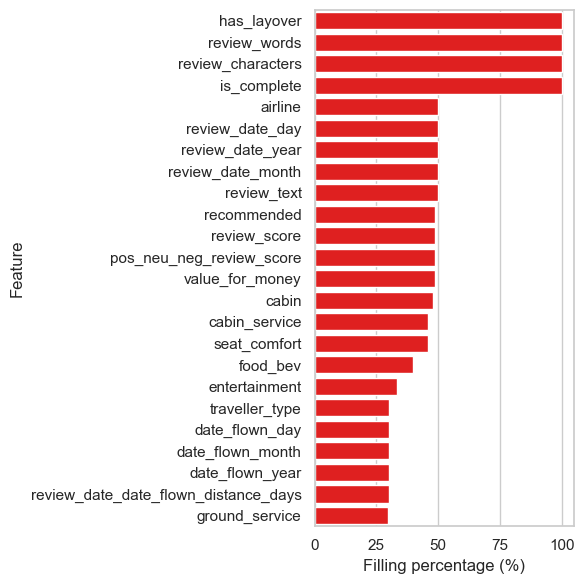

In [67]:
plt.figure(figsize=(6,6),dpi=100)
sns.set(style="whitegrid")
ax = sns.barplot(x=values_filling_rates, y=text_filling_rates,color="Red")
ax.set(xlabel='Filling percentage (%)', ylabel='Feature')
plt.tight_layout()
plt.show()

In [68]:
df_without_na_1 = df_aug[df_aug['airline'].notna()].copy()
df_without_na_1.shape

(65947, 24)

## 5.2 Iteration 2

In [69]:
# Percentage of non-null values.
filling_rates_without_na_1 = 100.*df_without_na_1.count().sort_values(ascending=False)/df_without_na_1.shape[0]
print(filling_rates_without_na_1)

airline                                 100.000000
review_date_day                         100.000000
has_layover                             100.000000
review_words                            100.000000
review_characters                       100.000000
is_complete                             100.000000
review_date_year                        100.000000
review_date_month                       100.000000
review_text                              99.884756
recommended                              97.714832
review_score                             97.073407
pos_neu_neg_review_score                 97.073407
value_for_money                          97.009720
cabin                                    95.990720
cabin_service                            92.066356
seat_comfort                             92.014800
food_bev                                 79.773151
entertainment                            67.012904
traveller_type                           60.283258
date_flown_day                 

In [70]:
values_filling_rates_without_na_1 = filling_rates_without_na_1.values
text_filling_rates_without_na_1 = filling_rates_without_na_1.index.to_list()
print(text_filling_rates)

['has_layover', 'review_words', 'review_characters', 'is_complete', 'airline', 'review_date_day', 'review_date_year', 'review_date_month', 'review_text', 'recommended', 'review_score', 'pos_neu_neg_review_score', 'value_for_money', 'cabin', 'cabin_service', 'seat_comfort', 'food_bev', 'entertainment', 'traveller_type', 'date_flown_day', 'date_flown_month', 'date_flown_year', 'review_date_date_flown_distance_days', 'ground_service']


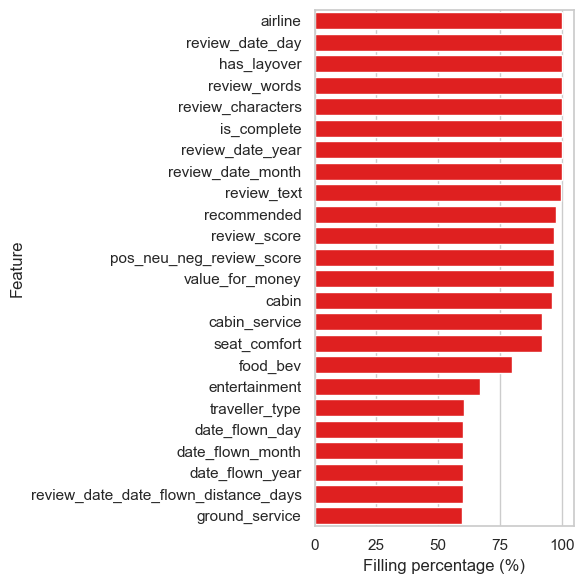

In [71]:
plt.figure(figsize=(6,6),dpi=100)
sns.set(style="whitegrid")
ax = sns.barplot(x=values_filling_rates_without_na_1, y=text_filling_rates_without_na_1,color="Red")
ax.set(xlabel='Filling percentage (%)', ylabel='Feature')
plt.tight_layout()
plt.show()

In [72]:
df_without_na_2 = df_without_na_1.dropna(axis=0,how='any').copy()
df_without_na_2.shape

(24563, 24)

In [73]:
n_reviews_without_na_2 = df_without_na_2.shape[0]
print('Number of customer reviews in the dataset, excluding all missing values: {:d}'.format(n_reviews_without_na_2))

Number of customer reviews in the dataset, excluding all missing values: 24563


In [74]:
f_reviews_without_na_2 = n_reviews_without_na_2/n_reviews
print('Fraction of the original dataset: {:f}'.format(f_reviews_without_na_2))

Fraction of the original dataset: 0.186231


We are down to 18% of the original data, because of the removal of the NaN values, but it is okay for us to train the model on clean data rather than NaN-filled messy data!

In [75]:
df_for_training = df_without_na_2.copy()
df_for_training['is_complete'].unique()

array([False,  True])

In [76]:
df_for_training.drop(columns=['is_complete'], inplace=True)

In [77]:
cols_for_training = df_for_training.columns.to_list()

# 6. Features distributions into Boolean, Categorical and Numerical types

In [78]:
feats_bool = ['recommended',
              'has_layover']
feats_cat = ['airline',
             'traveller_type',
             'cabin','review_text',
             'pos_neu_neg_review_score']
feats_num = [feat for feat in cols_for_training if feat not in feats_bool and feat not in feats_cat]

In [79]:
print('Boolean features: \n{}\n'.format(feats_bool))
print('Categorical features: \n{}\n'.format(feats_cat))
print('Numerical features: \n{}\n'.format(feats_num))

Boolean features: 
['recommended', 'has_layover']

Categorical features: 
['airline', 'traveller_type', 'cabin', 'review_text', 'pos_neu_neg_review_score']

Numerical features: 
['review_score', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'review_date_day', 'review_date_month', 'review_date_year', 'date_flown_day', 'date_flown_month', 'date_flown_year', 'review_date_date_flown_distance_days', 'review_characters', 'review_words']



# 7. Plotting the correlation matrix for the features

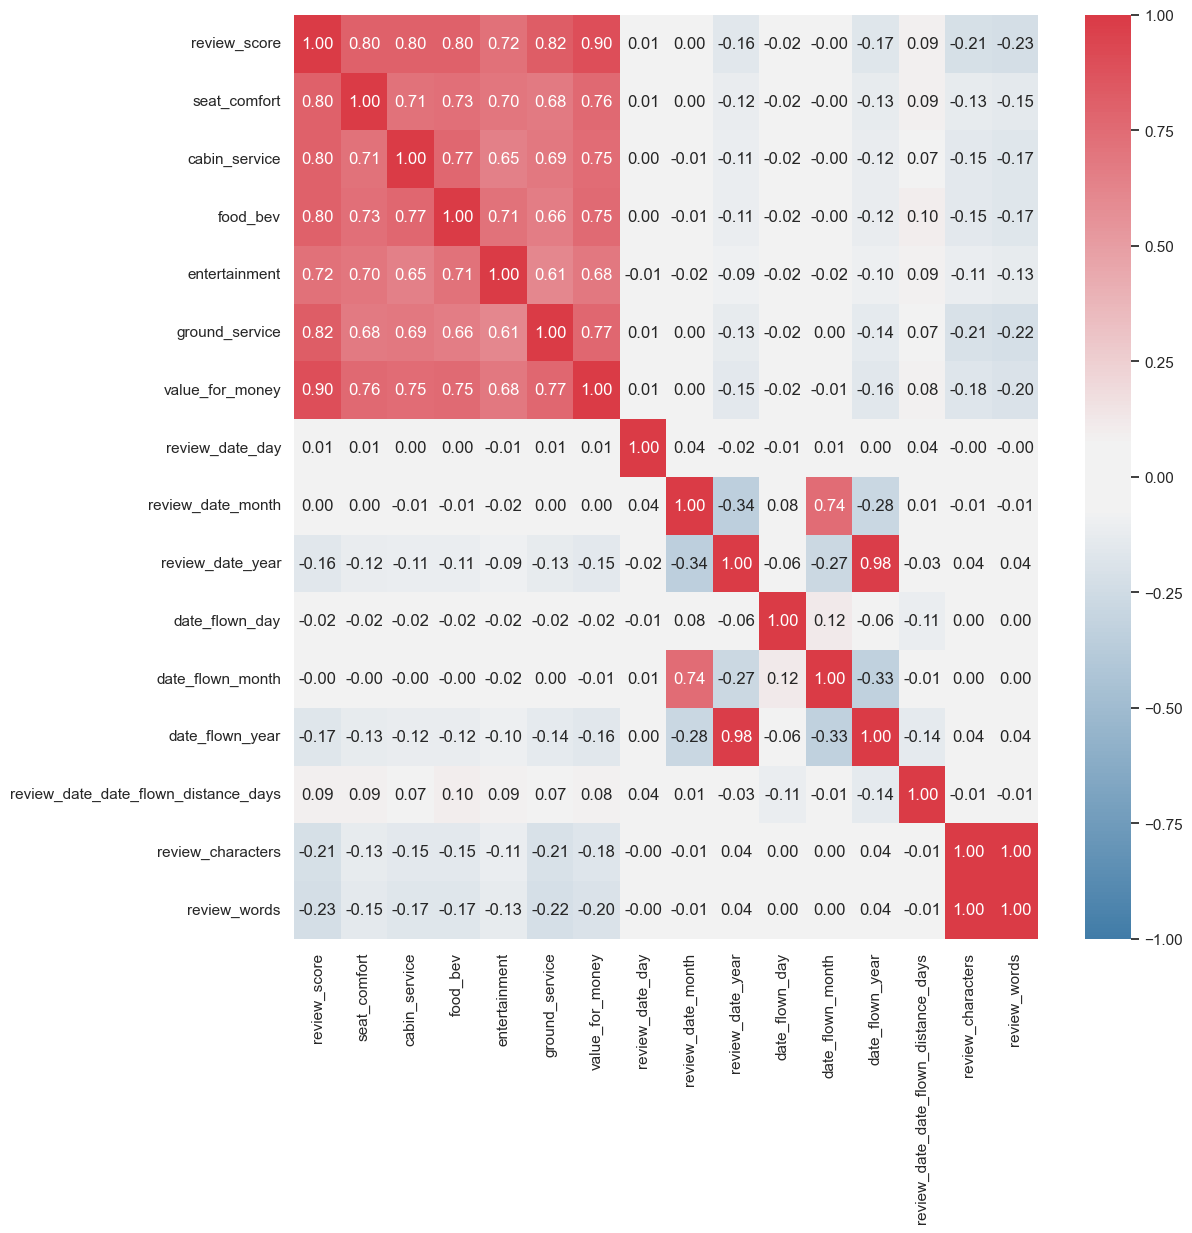

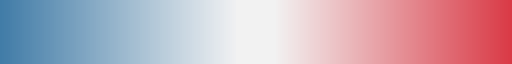

In [80]:
# Let's plot a correlation matrix among the features
def plot_cmap(matrix_values, figsize_w, figsize_h, filename):
    """
    Plot a heatmap corresponding to the input values.
    """
    if figsize_w is not None and figsize_h is not None:
        plt.figure(figsize=(figsize_w,figsize_h))
    else:
        plt.figure()
    cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
    sns.heatmap(matrix_values, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1)
    plt.savefig(filename)
    plt.show()
    return cmap
corr_values = df_for_training[feats_num].dropna(axis=0,how='any').corr()
plot_cmap(matrix_values=corr_values, 
          figsize_w=12, 
          figsize_h=12, 
          filename='./Corr.png')

Few points of notice:

* a positive correlation between the different types of review scores and subscores
* a negative correlation between the length of the review text and the value of the different types of review scores and subscores
* the similarity between using the number of characters and the number of words, from which we conclude that we can drop one of the two features

In [81]:
df_for_training_small = df_for_training.drop(columns=['review_words']).copy()

In [82]:
cols_for_training_small = df_for_training_small.columns.to_list()
feats_num_for_training_small = [feat for feat in cols_for_training_small if feat not in feats_bool and feat not in feats_cat]

In [83]:
print('Boolean features: \n{}\n'.format(feats_bool))
print('Categorical features: \n{}\n'.format(feats_cat))
print('Numerical features: \n{}\n'.format(feats_num_for_training_small))

Boolean features: 
['recommended', 'has_layover']

Categorical features: 
['airline', 'traveller_type', 'cabin', 'review_text', 'pos_neu_neg_review_score']

Numerical features: 
['review_score', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'review_date_day', 'review_date_month', 'review_date_year', 'date_flown_day', 'date_flown_month', 'date_flown_year', 'review_date_date_flown_distance_days', 'review_characters']



# 8. Unique value analysis for different categorical features

In [84]:
for col in df_for_training_small:
    print('Column:', col)
    print('Number of unique values:', df_for_training_small[col].nunique())
    if (col != 'review_text' and col != 'review_date_date_flown_distance_days' and col != 'review_characters'):
        print(df_for_training_small[col].unique())
    print('')

Column: airline
Number of unique values: 81
['Turkish Airlines' 'Qatar Airways' 'Emirates' 'Lufthansa'
 'KLM Royal Dutch Airlines' 'Virgin America' 'American Airlines'
 'Delta Air Lines' 'Southwest Airlines' 'United Airlines'
 'Jetblue Airways' 'Aegean Airlines' 'Aeroflot Russian Airlines'
 'Aeromexico' 'Air Canada' 'Air New Zealand' 'Alitalia' 'AirAsia'
 'Asiana Airlines' 'Avianca' 'Austrian Airlines' 'British Airways'
 'Brussels Airlines' 'China Eastern Airlines' 'China Southern Airlines'
 'Copa Airlines' 'Ethiopian Airlines' 'Egyptair' 'Finnair' 'Iberia'
 'ANA All Nippon Airways' 'easyJet' 'Korean Air' 'LATAM Airlines'
 'LOT Polish Airlines' 'Qantas Airways' 'Air France' 'Etihad Airways'
 'Pegasus Airlines' 'Royal Jordanian Airlines' 'Ryanair'
 'South African Airways' 'Saudi Arabian Airlines' 'TAP Portugal'
 'Eurowings' 'EVA Air' 'Royal Air Maroc' 'Singapore Airlines'
 'SAS Scandinavian' 'Swiss Intl Air Lines' 'Thai Airways' 'Air India'
 'Air Europa' 'Air Canada rouge' 'airBaltic' '

In [85]:
for col in df_for_training_small:
    print('Column:', col)
    print('Number of unique values:', df_for_training_small[col].nunique())
    if (col != 'review_text' and col != 'review_date_date_flown_distance_days' and col != 'review_characters'):
        print(df_for_training_small.groupby([col]).size().sort_values(ascending=False))
    print('')

Column: airline
Number of unique values: 81
airline
Cathay Pacific Airways     1354
American Airlines          1330
United Airlines            1292
British Airways            1257
China Southern Airlines    1151
                           ... 
Thai Smile Airways           12
Tunisair                     10
Adria Airways                 9
Germanwings                   6
QantasLink                    4
Length: 81, dtype: int64

Column: review_score
Number of unique values: 10
review_score
1     6286
9     3156
10    3105
8     2742
2     2431
7     1771
3     1769
5     1156
4     1107
6     1040
dtype: int64

Column: traveller_type
Number of unique values: 4
traveller_type
Solo Leisure      9159
Couple Leisure    6246
Family Leisure    4686
Business          4472
dtype: int64

Column: cabin
Number of unique values: 4
cabin
Economy Class      17662
Business Class      4859
Premium Economy     1318
First Class          724
dtype: int64

Column: seat_comfort
Number of unique values: 5
seat

In [86]:
def plot_bar(df,feat,filename,horizontal=False,figsize_w=None,figsize_h=None):
    """
    Plot the bar of occurrences of each value of a given feature.
    """
    print('Feature: {}'.format(feat))
    keys_list = []
    entries_list = []
    keys = df[feat].unique()
    entries_dict = {}
    for key in keys:
        entries_dict[key] = np.sum(df[feat]==key)
    entries_dict_ordered = {k: v for k, v in sorted(entries_dict.items(), reverse=True, key=lambda item: item[1])}
    keys_list = list(entries_dict_ordered.keys())
    entries_list = list(entries_dict_ordered.values())
    #print('Values of the feature:', keys_list)
    #print('Frequencies of the feature:', entries_list)
    if figsize_w is not None and figsize_h is not None:
        plt.figure(figsize=(figsize_w,figsize_h))
    else:
        plt.figure(figsize=(6,6))
    sns.set(style="whitegrid")
    if horizontal==True:
        ax = sns.barplot(x=entries_list, y=keys_list,color="Red")
        ax.set(xlabel='Frequency', ylabel=feat)
    else:
        ax = sns.barplot(x=keys_list, y=entries_list,color="Red")
        ax.set(xlabel=feat, ylabel='Frequency')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    return


Feature: airline


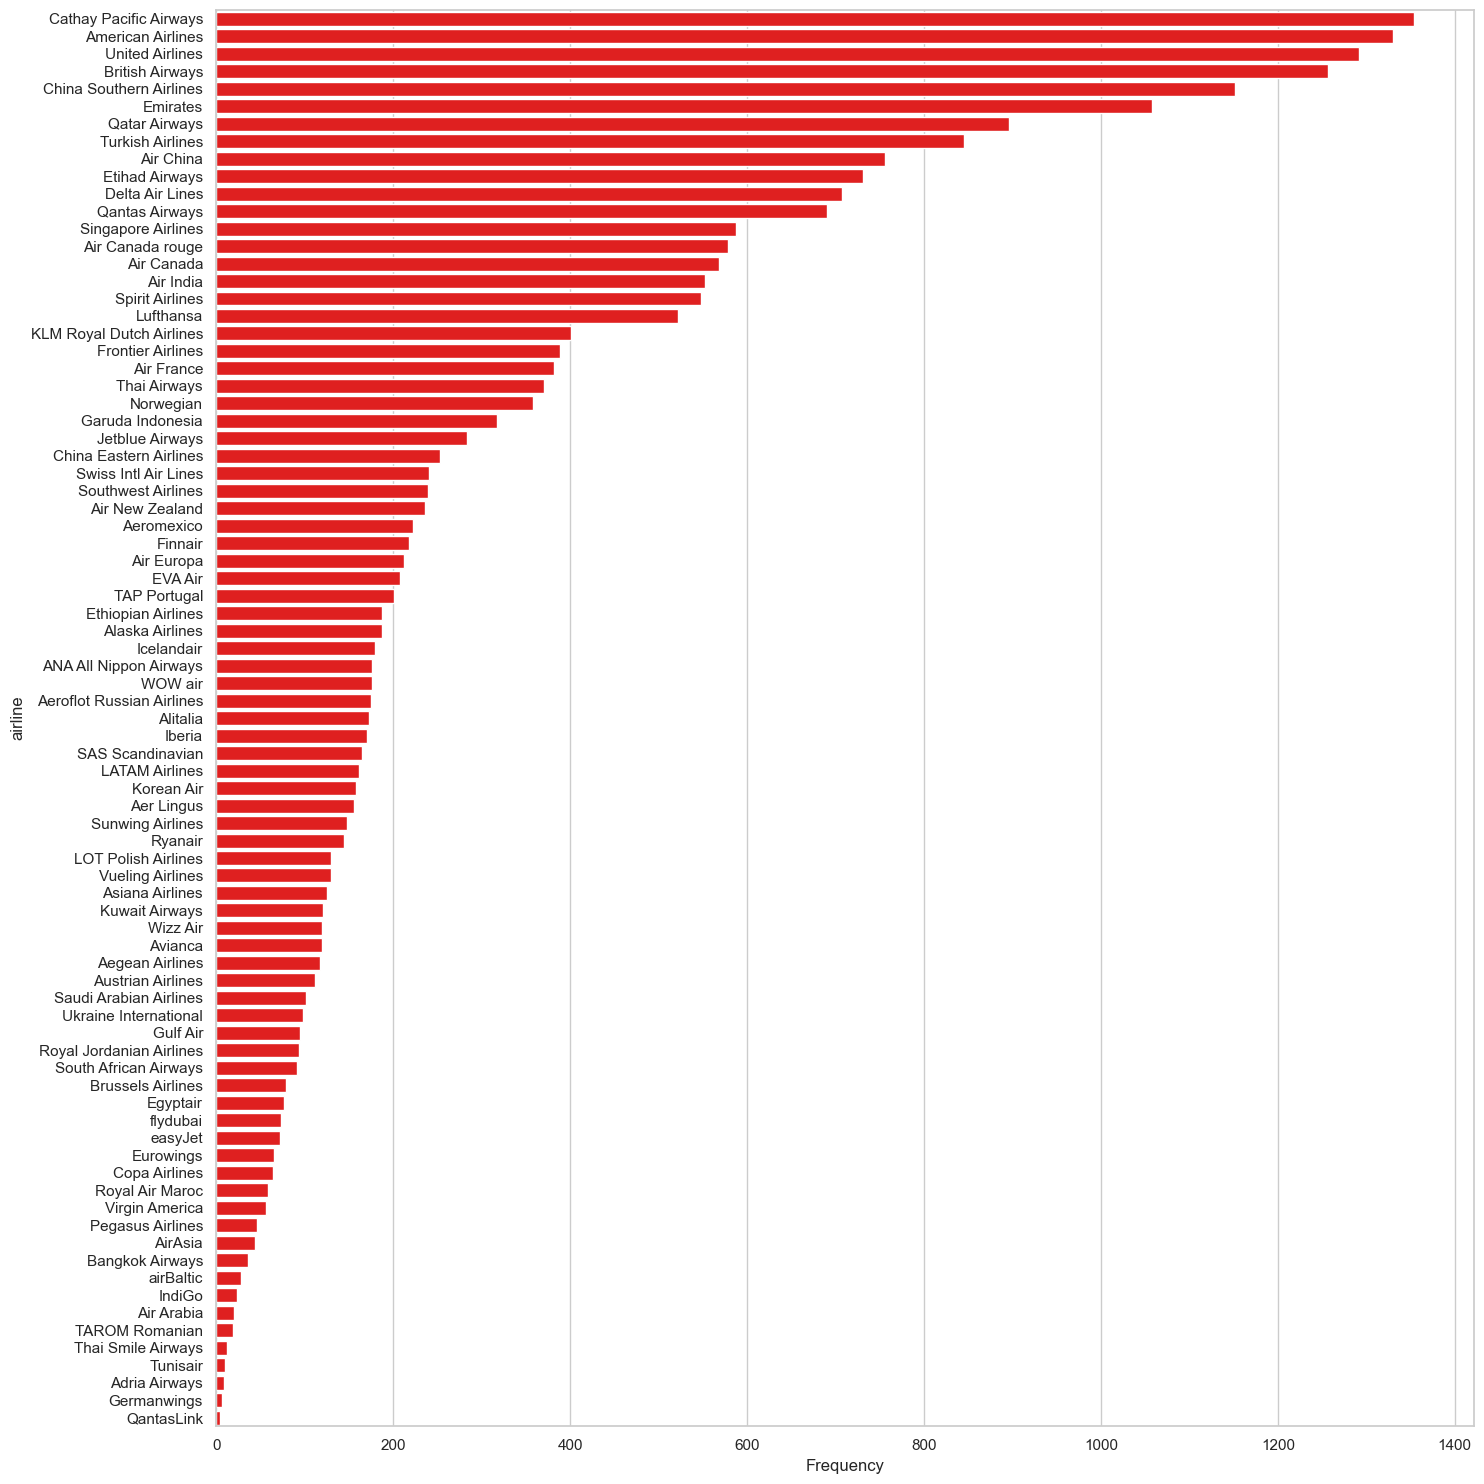

Feature: traveller_type


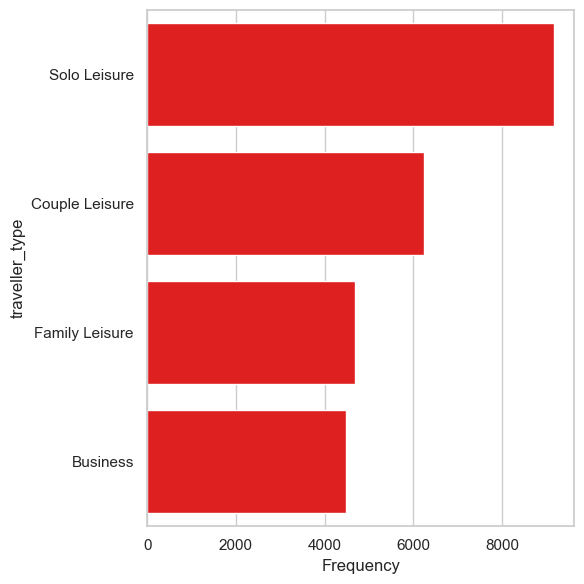

Feature: cabin


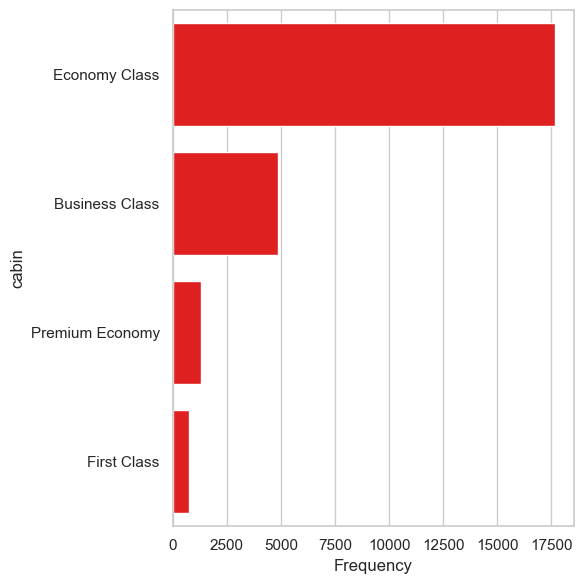

Feature: pos_neu_neg_review_score


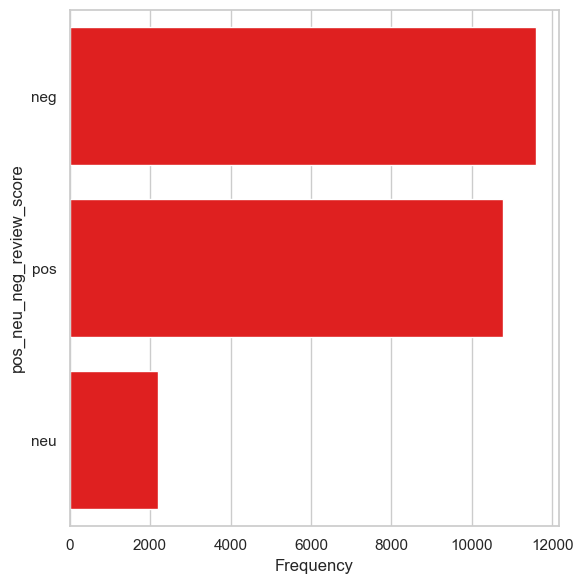

In [87]:
# Bar plot of occurrences of each value of each categorical feature.
for feat in feats_cat:
    if (feat != 'review_text' and feat != 'origin_city' and feat != 'destination_city' and feat != 'layover_city'):
        if (feat == 'airline'):
            plot_bar(df=df_for_training_small,
                              feat=feat,
                              filename='./CatFeatureValues-'+feat+'.png',
                              horizontal=True,
                              figsize_w=15,
                              figsize_h=15)
        else:
            plot_bar(df=df_for_training_small,
                              feat=feat,
                              filename='./CatFeatureValues-'+feat+'.png',
                              horizontal=True,
                              figsize_w=None,
                              figsize_h=None)

Out of the total number of selected customer reviews (24563):

* There are 81 distinct airlines, assuming the same airline does not have different abbreviations or ways to spell their name. The airlines are not equally represented in the dataset. The most represented airline is Cathay Pacific Airways and the least represented airline is QantasLink.
* The review dates cover 31 days, 12 months and 5 years, from 2015 to 2019.
* The dates flown cover 2 days, 12 months and 7 years, from 2013 to 2019. This means that passengers can submit a review several years after the date flown. Would it make sense to restrict the dataset to customer reviews submitted soon after the date flown? What could be the implications?
* There are 22814 distinct review texts but 24563 selected customer reviews. This means that some reviews might be identical. This should be investigated more in detail.
* The review score ranges from 1 to 10.
* The review subscores range from 1 to 5.
* There are 4 distinct traveller types (from the most represented to the least, solo leisure, couple leisure, business and family leisure).
* There are 4 distinct cabins (from the most represented to the least, economy class, business class, premium economy and first class).

# 9. Check for duplicate review texts

In [88]:
df_same_review_text = df_for_training_small.groupby('review_text')['review_text'].count().reset_index(name='n_reviews').sort_values(by='n_reviews',ascending=False)
df_same_review_text[df_same_review_text['n_reviews']>1]

,review_text,n_reviews
0,,6
5845,"For once, we have very positive things to say...",3
3054,Check in no hassle. The service was not as wa...,2
3026,Check in fast and friendly as everyone was in...,2
3027,"Check in fast and friendly, Lounge No 1 isnâ€...",2
...,...,...
997,Alcoholic drinks are for sale only during tra...,2
22148,While this was not the best airline I have fl...,2
11507,"Lovely flight, this plane is such an improvem...",2
11878,My first connection BOM-DEL was delayed with ...,2


In [89]:
df_for_training_small[df_for_training_small['review_text']==df_same_review_text.loc[5845,:]['review_text']]
df_for_training_small[df_for_training_small['review_text']==df_same_review_text.loc[5845,:]['review_text']][feats_bool]
df_for_training_small[df_for_training_small['review_text']==df_same_review_text.loc[5845,:]['review_text']][feats_num_for_training_small]
df_for_training_small[df_for_training_small['review_text']==df_same_review_text.loc[5845,:]['review_text']][feats_cat]

,airline,traveller_type,cabin,review_text,pos_neu_neg_review_score
37043,Air Canada,Couple Leisure,Economy Class,"For once, we have very positive things to say...",pos
90987,Air Canada rouge,Couple Leisure,Economy Class,"For once, we have very positive things to say...",pos
99363,Air Canada rouge,Couple Leisure,Economy Class,"For once, we have very positive things to say...",pos


Here it seems that a passenger left multiple customer reviews, identical to each other. These duplicates must be dropped from the dataset before model training, as they do not add any useful information.

In [90]:
df_no_duplicates = df_for_training_small.drop_duplicates().copy()

In [91]:
n_reviews_no_duplicates = df_no_duplicates.shape[0]
print('Number of customer reviews in the dataset, excluding all missing values and dropping duplicates: {:d}'.format(n_reviews_no_duplicates))
f_reviews_no_duplicates = n_reviews_no_duplicates/n_reviews
print('Fraction of the original dataset: {:f}'.format(f_reviews_no_duplicates))

Number of customer reviews in the dataset, excluding all missing values and dropping duplicates: 22822
Fraction of the original dataset: 0.173032


Now we're down to around 17% of the original data!! But it is all clean.

# 10. Plotting the review scores 

## 10.1 Review Scores

In [92]:
def plot_grouped_box(df,feat_x,feat_y,filename):
    """
    Plot the distribution of feat_x for different values of feat_y.
    """
    plt.figure(figsize=(6,6))
    sns.set(style="whitegrid")
    ax = sns.catplot(data=df, x=feat_x, y=feat_y, kind='box', palette='Set2')
    ax.set(xlabel=feat_x, ylabel=feat_y)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    return

Feature: review_score


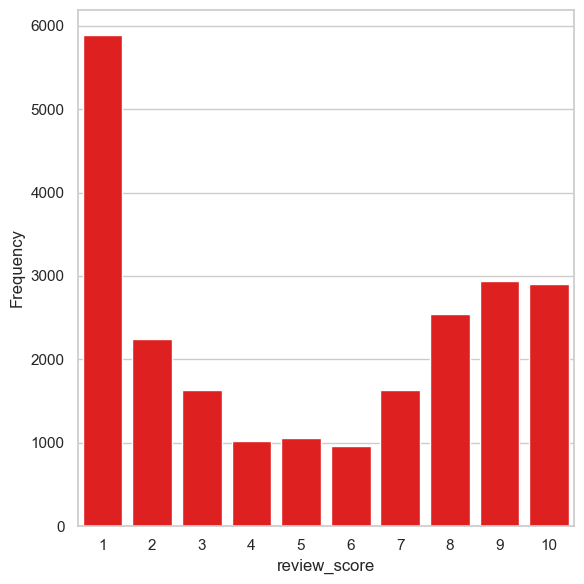

In [93]:
feat = 'review_score'
plot_bar(df_no_duplicates,feat,'./Bar-'+feat+'.png')

<Figure size 600x600 with 0 Axes>

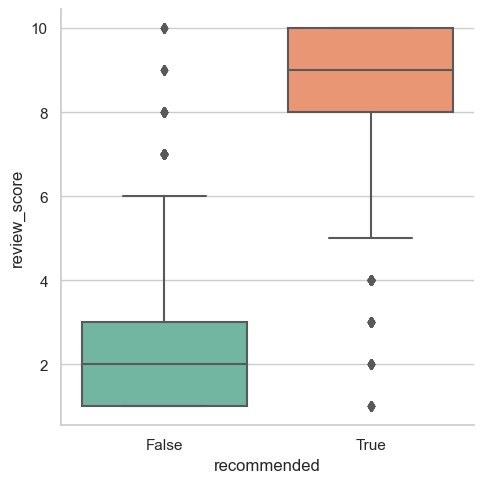

In [94]:
feat_x = 'recommended'
feat_y = 'review_score'
plot_grouped_box(df_no_duplicates,feat_x,feat_y,'./Box-'+feat_x+'-'+feat_y+'.png')

<Figure size 600x600 with 0 Axes>

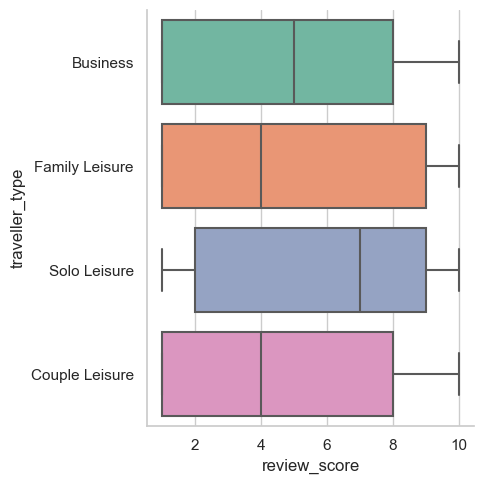

In [95]:
feat_x = 'review_score'
feat_y = 'traveller_type'
plot_grouped_box(df_no_duplicates,feat_x,feat_y,'./Box-'+feat_x+'-'+feat_y+'.png')

<Figure size 600x600 with 0 Axes>

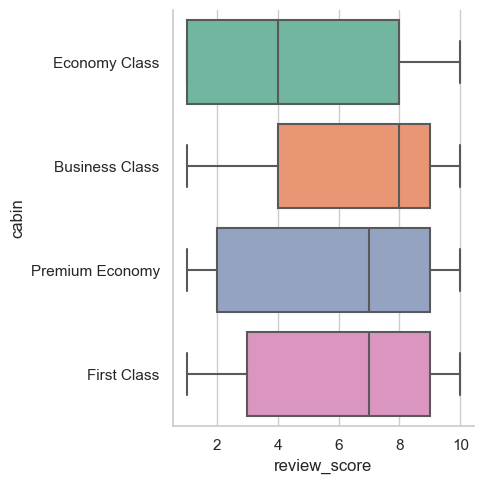

In [96]:
feat_x = 'review_score'
feat_y = 'cabin'
plot_grouped_box(df_no_duplicates,feat_x,feat_y,'./Box-'+feat_x+'-'+feat_y+'.png')

## 10.2 Review Date

Feature: review_date_month


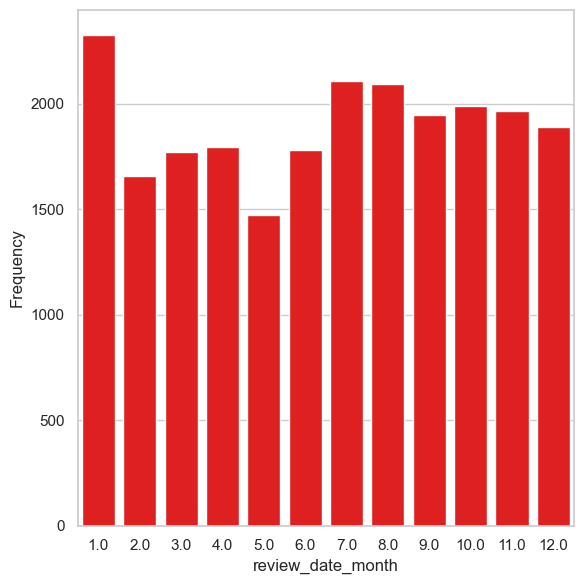

In [97]:
feat = 'review_date_month'
plot_bar(df_no_duplicates,feat,'./Bar-'+feat+'.png')

Feature: review_date_year


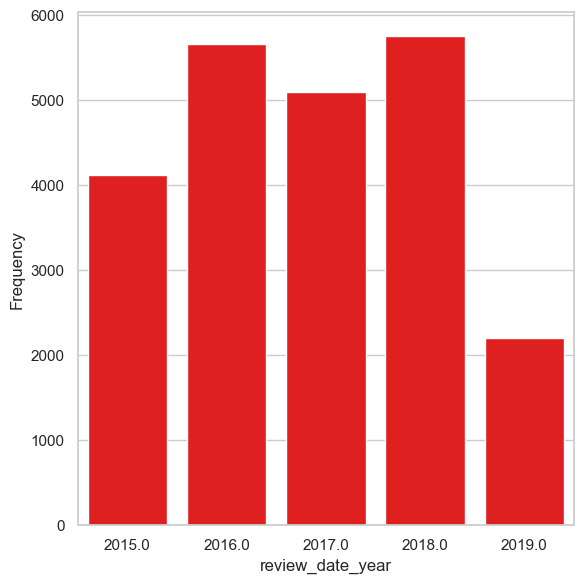

In [98]:
feat = 'review_date_year'
plot_bar(df_no_duplicates,feat,'./Bar-'+feat+'.png')

## 10.3 Flown Date

Feature: date_flown_month


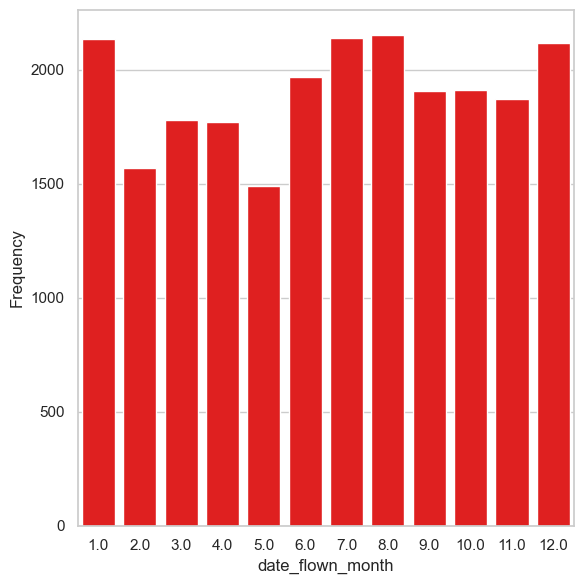

In [99]:
feat = 'date_flown_month'
plot_bar(df_no_duplicates,feat,'./Bar-'+feat+'.png')

Feature: date_flown_year


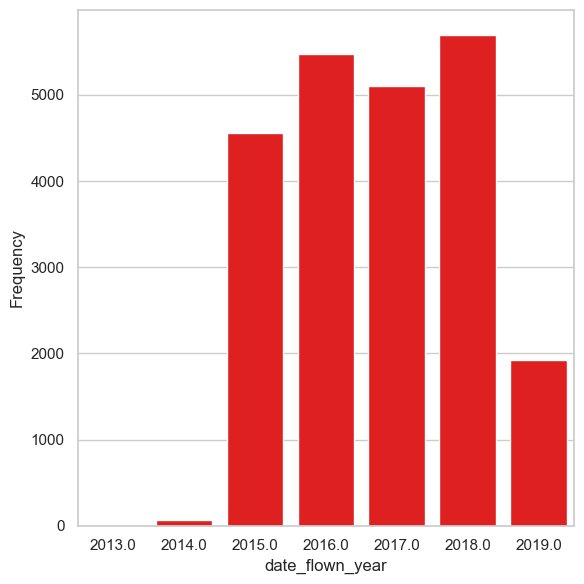

In [100]:
feat = 'date_flown_year'
plot_bar(df_no_duplicates,feat,'./Bar-'+feat+'.png')

## 10.4 Distance of days between date flown and review date

In [101]:
def plot_hist(df,feat,bins,filename,x_min=None,x_max=None):
    """
    Plot the histogram of occurrences of each value of a given feature.
    """
    print('Feature: {}'.format(feat))
    plt.figure(figsize=(6,6))
    plt.hist(df[feat],bins=bins,color='red')
    if x_min is not None and x_max is not None:
        plt.xlim(x_min,x_max)
    plt.xlabel(feat)
    plt.ylabel('Entries / bin')
    plt.savefig(filename)
    plt.show()
    return

Feature: review_date_date_flown_distance_days


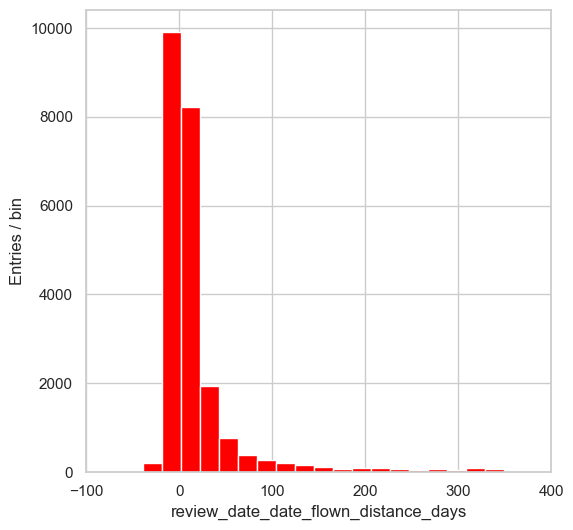

In [102]:
feat = 'review_date_date_flown_distance_days'
plot_hist(df=df_no_duplicates,
          feat=feat,
          bins=100,
          x_min=-100,
          x_max=400,
          filename='./Hist-'+feat+'.png')

## 10.5 Review Length

Feature: review_characters


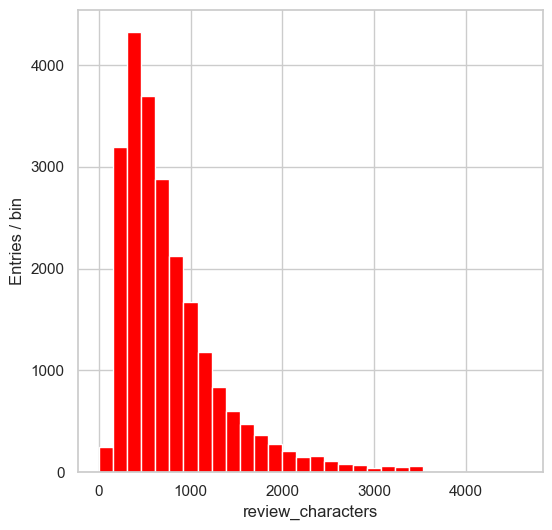

In [103]:
feat = 'review_characters'
plot_hist(df=df_no_duplicates,
          feat=feat,
          bins=30,
          filename='./Hist-'+feat+'.png')

In [104]:
def plot_two_hists_comp_sns(df_1,df_2,label_1,label_2,feat,bins,title,x_label,y_label,filename):
    """
    Plot two histograms of a given feature in two different datasets.
    """
    plt.figure(figsize=(6,6))
    sns.distplot(df_1[feat],hist=True,norm_hist=True,kde=False,label=label_1,bins=bins)
    sns.distplot(df_2[feat],hist=True,norm_hist=True,kde=False,label=label_2,bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(False)
    plt.legend(loc='best')
    plt.savefig(filename)
    plt.show()
    return

## 10.6 Relation between recommendation and review score

In [105]:
df_recommended = df_no_duplicates[df_no_duplicates['recommended']==True].copy()
df_not_recommended = df_no_duplicates[df_no_duplicates['recommended']==False].copy()

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


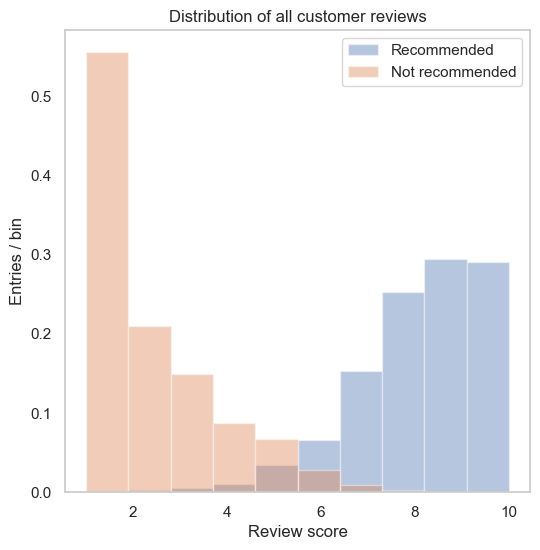

In [106]:
plot_two_hists_comp_sns(df_1=df_recommended,
                        df_2=df_not_recommended,
                        label_1='Recommended',
                        label_2='Not recommended',
                        feat='review_score',
                        bins=10,
                        title='Distribution of all customer reviews',
                        x_label='Review score',
                        y_label='Entries / bin',
                        filename='./HistRecAndNotRec.png'
                        )

Positive customer reviews tend to be shorter than negative customer reviews (see mean of the distribution of the number of characters in the customer review). The same trend is observed if using the number of words instead of the number of characters.

## 10.7 Relationship between review score and length of the review text

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


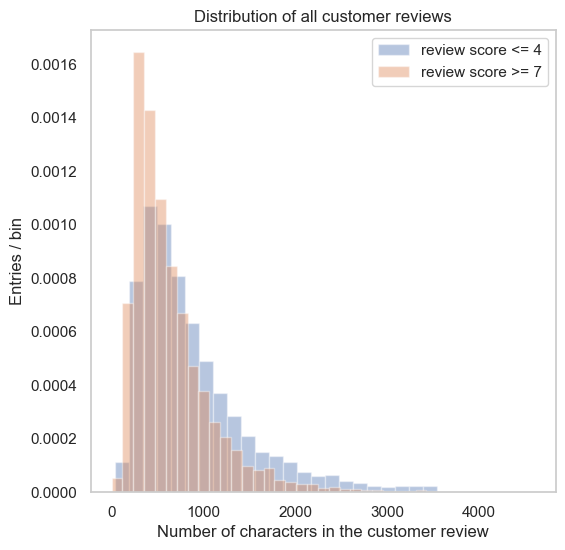

In [107]:
plot_two_hists_comp_sns(df_1=df_no_duplicates[df_no_duplicates['review_score']<=4],
                        df_2=df_no_duplicates[df_no_duplicates['review_score']>=7],
                        label_1='review score <= 4',
                        label_2='review score >= 7',
                        feat='review_characters',
                        bins=30,
                        title='Distribution of all customer reviews',
                        x_label='Number of characters in the customer review',
                        y_label='Entries / bin',
                        filename='./HistReviewCharactersByReviewScore.png')

# 11. Filter out all airlines except any from Middle East.

In [203]:
df_no_duplicates.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,review_date_month,review_date_year,date_flown_day,date_flown_month,date_flown_year,review_date_date_flown_distance_days,review_characters,pos_neu_neg_review_score,has_layover,recommended
1,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,5.0,2019.0,1.0,5.0,2019.0,7.0,1094,pos,True,True
3,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,5.0,2019.0,1.0,5.0,2019.0,6.0,425,neg,False,False
5,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,2,...,5.0,2019.0,1.0,5.0,2019.0,6.0,1597,neg,True,False
7,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,5,...,5.0,2019.0,21.0,4.0,2019.0,15.0,875,pos,False,True
9,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,1,...,5.0,2019.0,1.0,5.0,2019.0,5.0,366,neg,True,False


In [204]:
df = df_no_duplicates
df = df[df['airline'].isin(['Turkish Airlines', 'Qatar Airways', 'Emirates', 'Etihad Airways',
       'Royal Jordanian Airlines', 'Saudi Arabian Airlines', 'flydubai',
       'Gulf Air', 'Kuwait Airways'])]

In [205]:
df.reset_index(drop=True, inplace=True)
df.shape

(4012, 22)

Get the names of the columns

In [206]:
cols = df.columns.to_list()
print('Columns in the dataset:')
print(cols)

Columns in the dataset:
['airline', 'review_score', 'traveller_type', 'cabin', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'review_text', 'review_date_day', 'review_date_month', 'review_date_year', 'date_flown_day', 'date_flown_month', 'date_flown_year', 'review_date_date_flown_distance_days', 'review_characters', 'pos_neu_neg_review_score', 'has_layover', 'recommended']


Get the total number of reviews in the dataset

In [207]:
n_reviews = df.shape[0]
print('Number of customer reviews in the dataset: {:d}'.format(n_reviews))

Number of customer reviews in the dataset: 4012


# 12. Analysing the sentiment of the review text

## 12.1 Review text and a new dataframe for NLP

In [208]:
# Save the review text to a new list
reviews_list = df['review_text'].copy()
reviews_list.shape

(4012,)

In [209]:
# Copy for the sake of tackling the ambiguity
df_nlp = df.copy()

## 12.2 Sentiment Analysis using VADER

Sentiment analysis is the field of NLP that aims at understanding the sentiment of a certain portion of text. One of the best-known packages for sentiment analysis is the open-source package VADER, which is part of NLTK.

VADER, acronym for Valence Aware Dictionary and sEntiment Reasoner, is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.
VADER is built on social media text but it is in general applicable to other domains, including customer reviews.
VADER is based on a lexicon (vocabulary) that is validated by multiple human judges according to a well-defined and standard procedure. Each word in the lexicon is associated with a sentiment valence, consisting of two properties, polarity and intensity. The polarity describes if the text is positive/negative. The intensity describes how much the text is positive/negative, on a scale from -4 to 4. Words not included in the lexicon are classified as neutral.

To evaluate the sentiment of a sentence or list of sentences, VADER looks for words in the text that are part of the lexicon, modifies the intensity and polarity of the identified words according to a series of rules, sums up these values and then normalises to the range [-1,1].
VADER incorporates emojis (for example ":-)"), acronyms (for example "LOL") and slang (for example "nah"). The algorithm differs from a Bag of Words approach as it takes words order and degree modifiers into account, e.g. by increasing/decreasing the intensity of the sentiment.
For example, the sentences:

* "I liked Forrest Gump."
* "I really liked Forrest Gump."
* "Forrest Gump is a GREAT movie."
* "Forrest Gump is perhaps the GREATEST movie ever!"
* "Forrest Gump is one of the GREATEST movie of all time! :)"

    would have an increasing intensity, triggered by degree modifiers.
   
The output of the sentiment analysis is a series of scores, namely "compound", "pos", "neu" and "neg".
The compound score is normalized between -1 (extremely negative) and 1 (extremely positive) and is a good metric if we need a single value that summarises the sentiment of a given sentence. The compound score can also be used to classify sentences into positive, neutral and negative by setting an appropriate threshold on the compound score. The official recommended threshold is:

* positive sentiment, compound score >= 0.05
* neutral sentiment, compound score <= 0.05 and >= -0.05
* negative sentiment, compound score <= -0.05

The positive, neutral and negative scores represent the fraction of the sentence that has a positive, neutral and negative sentiment. The sum of these three scores should sum up to 1. The positive, neutral and negative scores are a good metric if we need multiple values that summarise the sentiment of a given sentence.

In [210]:
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [211]:
sid = SentimentIntensityAnalyzer()

In [212]:
# Example of VADER sentiment analyzer on different intensity sentences.
print(sid.polarity_scores("I liked Forrest Gump."))
print(sid.polarity_scores("I really liked Forrest Gump."))
print(sid.polarity_scores("Forrest Gump is a GREAT movie."))
print(sid.polarity_scores("Forrest Gump is perhaps the GREATEST movie ever!"))
print(sid.polarity_scores("Forrest Gump is one of the GREATEST movie of all time! :)"))

{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.4215}
{'neg': 0.0, 'neu': 0.492, 'pos': 0.508, 'compound': 0.4754}
{'neg': 0.0, 'neu': 0.453, 'pos': 0.547, 'compound': 0.7034}
{'neg': 0.0, 'neu': 0.573, 'pos': 0.427, 'compound': 0.7371}
{'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'compound': 0.8491}


In [213]:
review = reviews_list[0]
review_tok = tokenize.sent_tokenize(review)
print(review_tok)

[' First time Iâ€™d flown TK.', 'I found them very good in the air, cabin crew, planes, food, all very nice.', 'Not so great on the ground, ground staff, call centre, computer systems.', 'My flight from LHR was delayed so I missed the connection in Istanbul.', 'Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English.', 'I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport.', 'Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats.', 'However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat.', 'Luckily there was a spare exit row seat and the cabin crew sorted me out.', 'Overall, I think their cabin crew and planes are very good, g

In [214]:
# Example of VADER sentiment analyzer on first review of our dataset
print('Review text:')
print(review)

review_polarity_scores = sid.polarity_scores(review)

for key in sorted(review_polarity_scores.keys()):
    print('{}: {}, '.format(key,review_polarity_scores[key]), end='')
print('\n')

Review text:
 First time Iâ€™d flown TK. I found them very good in the air, cabin crew, planes, food, all very nice. Not so great on the ground, ground staff, call centre, computer systems. My flight from LHR was delayed so I missed the connection in Istanbul. Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English. I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats. However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat. Luckily there was a spare exit row seat and the cabin crew sorted me out. Overall, I think their cabin crew and planes are very good, ground staff and 

In [215]:
# Example on a sentence level.

# print('Review text:')
# print(review_tok)

for sentence in review_tok:
    print('Sentence text:')
    print(sentence)
    sentence_polarity_scores = sid.polarity_scores(sentence)

    for key in sorted(sentence_polarity_scores.keys()):
        print('{}: {}, '.format(key,sentence_polarity_scores[key]), end='')
    print('\n')

Sentence text:
 First time Iâ€™d flown TK.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Sentence text:
I found them very good in the air, cabin crew, planes, food, all very nice.
compound: 0.742, neg: 0.0, neu: 0.656, pos: 0.344, 

Sentence text:
Not so great on the ground, ground staff, call centre, computer systems.
compound: -0.544, neg: 0.242, neu: 0.758, pos: 0.0, 

Sentence text:
My flight from LHR was delayed so I missed the connection in Istanbul.
compound: -0.5812, neg: 0.323, neu: 0.677, pos: 0.0, 

Sentence text:
Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English.
compound: -0.34, neg: 0.124, neu: 0.876, pos: 0.0, 

Sentence text:
I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport.
compound: -0.0772, neg: 0.109, neu: 0.789, pos: 0.101, 

Sentence text:
Also, Iâ€™d pho

In [216]:
# Augment the dataset with the overall polarity score of the review, as obtained using VADER on the review level.
reviews_polarity = []

for i_review, review in enumerate(reviews_list):
    # print('Review text:')
    # print(review)

    review_polarity_scores = sid.polarity_scores(review)
    review_polarity_score_compound = review_polarity_scores['compound']
    
    '''Uncomment this to print the sentiment score of every review in the dataset.
    
    print('Review #{:d}: '.format(i_review), end='')
    for key in sorted(review_polarity_scores.keys()):
        print('{}: {:.4f}, '.format(key,review_polarity_scores[key]), end='')
    print('')  '''
    
    reviews_polarity.append(review_polarity_score_compound)

# print(reviews_polarity)

In [217]:
df_nlp['polarity'] = reviews_polarity
df_nlp.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,review_date_year,date_flown_day,date_flown_month,date_flown_year,review_date_date_flown_distance_days,review_characters,pos_neu_neg_review_score,has_layover,recommended,polarity
0,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,2019.0,1.0,5.0,2019.0,7.0,1094,pos,True,True,0.9365
1,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,2019.0,1.0,5.0,2019.0,6.0,425,neg,False,False,0.2732
2,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,2,...,2019.0,1.0,5.0,2019.0,6.0,1597,neg,True,False,-0.9483
3,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,5,...,2019.0,21.0,4.0,2019.0,15.0,875,pos,False,True,0.9718
4,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,1,...,2019.0,1.0,5.0,2019.0,5.0,366,neg,True,False,-0.7599


## 12.3 Plotting the correlation between Polarity and Recommendation

In [218]:
corr_values = df_nlp[['polarity','recommended']].dropna(axis=0,how='any').corr()

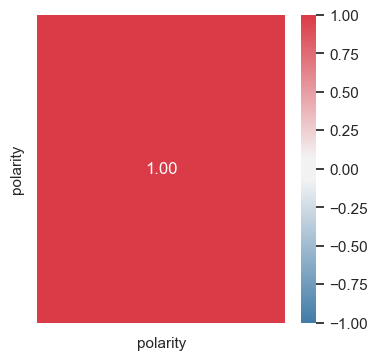

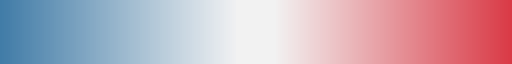

In [219]:
def plot_cmap(matrix_values, figsize_w, figsize_h, filename):
    """
    Plot a heatmap corresponding to the input values.
    """
    if figsize_w is not None and figsize_h is not None:
        plt.figure(figsize=(figsize_w,figsize_h))
    else:
        plt.figure()
    cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
    sns.heatmap(matrix_values, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1)
    plt.savefig(filename)
    plt.show()
    return cmap

plot_cmap(matrix_values=corr_values, 
          figsize_w=4, 
          figsize_h=4,
          filename='./Corr.png')

## 12.4 Plotting comparison of histograms for positive and negative customer reviews

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


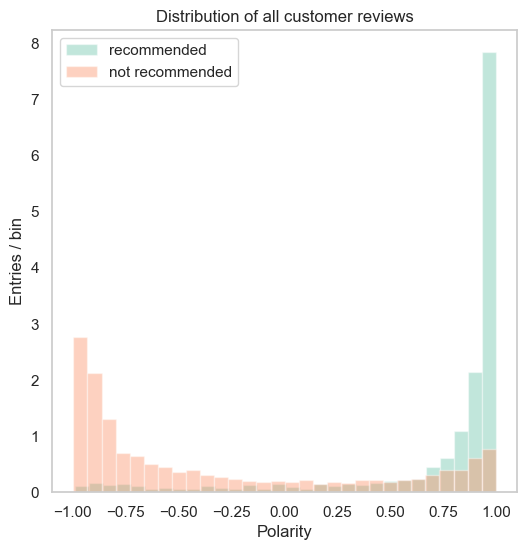

In [220]:
def plot_two_hists_comp_sns(df_1,df_2,label_1,label_2,feat,bins,title,x_label,y_label,filename):
    """
    Plot two histograms of a given feature in two different datasets.
    """
    plt.figure(figsize=(6,6))
    sns.distplot(df_1[feat],hist=True,norm_hist=True,kde=False,label=label_1,bins=bins)
    sns.distplot(df_2[feat],hist=True,norm_hist=True,kde=False,label=label_2,bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(False)
    plt.legend(loc='best')
    plt.savefig(filename)
    plt.show()
    return

plot_two_hists_comp_sns(df_1=df_nlp[df_nlp['recommended']==True],
                        df_2=df_nlp[df_nlp['recommended']==False],
                        label_1='recommended',
                        label_2='not recommended',
                        feat='polarity',
                        bins=30,
                        title='Distribution of all customer reviews',
                        x_label='Polarity',
                        y_label='Entries / bin',
                        filename='./HistPolarityByRecommendation.png')

## 12.5 Preprocess review text

In [221]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### 12.5.1 Handling stopwords

In [222]:
# Stop words.
# Airlines appearing in the dataset. This is the official name of the airlines. These words should be removed from the review text.
airlines_lower = df_nlp['airline'].str.lower().unique().tolist()
# Words appearing in the official name of the airlines. These words should be removed from the review text.
airlines_identifier = ['airlines',
                       'air lines',
                       'airline',
                       'air line',
                       'airways',
                       'air']
# In addition to the official name of the airlines, customers can use shortened versions of this name.
airlines_informal_lower = []
for airline in airlines_lower:
    found = False
    for airline_identifier in airlines_identifier:
        if found == False:
            if str(' '+airline_identifier) in airline:
                airline_informal = airline.replace(str(' '+airline_identifier),'')
                airlines_informal_lower.append(airline_informal)
                found = True
# Other stop words.
additional_stopwords = ['one','get','also','however','even','make']

In [223]:
nltk_stopwords = stopwords.words('english')
nltk_stopwords_extended = nltk_stopwords + airlines_lower + airlines_identifier + airlines_informal_lower + additional_stopwords
print('Number of stopwords in NLTK: {:d}'.format(len(nltk_stopwords)))
print('Number of stopwords after extension: {:d}'.format(len(nltk_stopwords_extended)))

Number of stopwords in NLTK: 179
Number of stopwords after extension: 207


### 12.5.2 Handling the cases & punctuation; tokenizing & lemmatizing the text; assign POS tagging

First of all, convert all characters in the review text to lower case.

After that, remove the punctuation and tokenize each customer review into a list of individual words.

As a next step, select only those words in the review text that could be relevant to solve the problem at hand. In particular, all stop words should be filtered out as they do not affect the meaning of the sentence.

Then, proceed to POS tagging, which allows to identify the role of each word in the sentence, according to the categories noun, verb, adjective, adverb and others. This is needed for a correct lemmatization of the words in the review text.

The lemmatization consists in bringing the words to their "standard" form, e.g. to convert "wrote" to "write" or "writing" to write.

In [224]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def text_cleaner(text):
    # Transform the text so that all words are lower case.
    # print(text)
    text = text.lower()
    # Remove stop words corresponding to airlines. This is needed here as airline names can consist of multiple words and will not be removed after splitting by words.
    # print(text)
    for airline_lower in airlines_lower:
        text = text.replace(airline_lower, '')
    # Remove punctuation and tokenize the text into individual words.
    # print(text)
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # Remove words that contain numbers.
    # print(text)
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # Remove stop words.
    # print(text)
    text = [word for word in text if word not in nltk_stopwords_extended]
    # Remove empty tokens.
    # print(text)
    text = [word for word in text if len(word)>0]
    # POS tagging of the text.
    # print(text)
    pos_tags = pos_tag(text)
    # Lemmatize the text.
    # print(text)
    text = [WordNetLemmatizer().lemmatize(i_pos_tag[0], get_wordnet_pos(i_pos_tag[1])) for i_pos_tag in pos_tags]
    # Remove words with only one letter.
    # print(text)
    text = [word for word in text if len(word)>1]
    # Join the text with space as a word delimiter.
    # print(text)
    text = " ".join(text)
    # Remove non-ASCII characters.
    printable = set(string.printable)
    text = ''.join(filter(lambda x: x in printable, text))
    return text

In [225]:
# Example of POS tagging.
pos_tag(tokenize.word_tokenize('A sample to show POS tagging'))

[('A', 'DT'),
 ('sample', 'NN'),
 ('to', 'TO'),
 ('show', 'VB'),
 ('POS', 'NNP'),
 ('tagging', 'VBG')]

In [226]:
text_cleaner(reviews_list[0])

'first time id flown tk find good cabin crew plane food nice great ground ground staff call centre computer system flight lhr delay miss connection istanbul ground staff dont speak english give contradictory instruction could speak little english eventually get flight izmir three hour later wasnt easy process make bad vast distance walk gate cavernous new airport id phone tk call centre base ukraine pay extra way extra leg room seat departure time keep change seat keep change return leg london istanbul give extra leg room seat luckily spare exit row seat cabin crew sort overall think cabin crew plane good ground staff call centre staff need good train need good computer system software work'

In [227]:
df_nlp['review_text_clean'] = df_nlp['review_text'].apply(lambda x: text_cleaner(x))

In [228]:
df_nlp['review_text_clean'][0]

'first time id flown tk find good cabin crew plane food nice great ground ground staff call centre computer system flight lhr delay miss connection istanbul ground staff dont speak english give contradictory instruction could speak little english eventually get flight izmir three hour later wasnt easy process make bad vast distance walk gate cavernous new airport id phone tk call centre base ukraine pay extra way extra leg room seat departure time keep change seat keep change return leg london istanbul give extra leg room seat luckily spare exit row seat cabin crew sort overall think cabin crew plane good ground staff call centre staff need good train need good computer system software work'

### 12.5.3 Vectorizing the text

We convert the text of each customer review from a textual representation to a numerical representation. The vectors of the numerical representation correspond to the words that appear in the preprocessed text of the customer reviews. The values in the numerical representation correspond to the occurrences of the specified word in the customer review. To avoid ending up with too many features in the numerical representation, we limit the dictionary to the words that appear at least a minimum number of times in the customer reviews. This threshold is specified through the parameter min_df of CountVectorizer.

For example, if we want to use a 3D numerical representation, we might have features corresponding to the words flight, service, food. For a certain customer review, the value of the feature flight will correspond to how many times flight is mentioned in the text, and similar for the other two features service and food.

In [229]:
# Make a list of the reviews.
corpus = df_nlp['review_text_clean'].values

In [230]:
vectorizer_ngrams = CountVectorizer(binary=False, ngram_range=(1, 1), analyzer='word', min_df=50)
vectorizer_ngrams.fit(corpus)

CountVectorizer(min_df=50)

In [231]:
vec_review_text_clean_feats = vectorizer_ngrams.get_feature_names_out()
vec_review_text_clean_feats[:10]

array(['able', 'absolutely', 'abu', 'accept', 'acceptable', 'access',
       'across', 'actually', 'add', 'additional'], dtype=object)

In [232]:
vec_review_text_clean = vectorizer_ngrams.transform(df_nlp['review_text_clean'])
print(vec_review_text_clean.shape)
print(vec_review_text_clean.dtype)

(4012, 855)
int64


In [233]:
vec_review_text_clean_feats_new = ['count_'+feat for feat in vec_review_text_clean_feats]
df_vec_review_text_clean = pd.DataFrame(vec_review_text_clean.toarray(),columns=vec_review_text_clean_feats_new)

In [234]:
df_vec_review_text_clean.head()

,count_able,count_absolutely,count_abu,count_accept,count_acceptable,count_access,count_across,count_actually,count_add,count_additional,...,count_work,count_world,count_worst,count_worth,count_would,count_write,count_wrong,count_year,count_yes,count_yet
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [235]:
df_nlp['review_text_clean'][1]

'check airport take luggage go gate gate surprise dont let u board two child say flight overbooked wait airport two child oclock morning bring u hotel hour far away airport without luggage without eat without nothing first last flight'

In [236]:
df_vec_review_text_clean.iloc[0]['count_lose']

0

In [240]:
df_nlp_final = pd.concat([df_nlp,df_vec_review_text_clean], axis=1)
df_nlp_final.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,count_work,count_world,count_worst,count_worth,count_would,count_write,count_wrong,count_year,count_yes,count_yet
0,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,1,0,0,0,0,0,0,0,0,0
1,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,2,...,0,0,0,1,0,0,0,1,0,0
3,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,5,...,0,0,0,0,0,0,0,0,0,0
4,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


# 13. Save the final processed data

In [241]:
#Remove review text column as we don't need it anymore
df_nlp_final = df_nlp_final.drop('review_text', axis=1)
df_nlp_final = df_nlp_final.drop('review_text_clean', axis=1)

In [239]:
df_nlp_final.to_csv('./ME_reviews_clean.csv', index=False)